In [1]:
import pandas as pd
pd.set_option('max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgbm

import os
import warnings
warnings.filterwarnings('ignore')

In [3]:
PATH_TO_DATA = '../data/raw'

# Data read

In [12]:
products = pd.read_csv(os.path.join(PATH_TO_DATA, 'products.csv'), index_col='product_id')
clients = pd.read_csv(os.path.join(PATH_TO_DATA, 'clients.csv'), index_col='client_id',
                                   parse_dates=['first_issue_date','first_redeem_date'])
purchases = pd.read_csv(os.path.join(PATH_TO_DATA, 'purchases.csv'), parse_dates=['transaction_datetime'], index_col=0)

In [13]:
df_train = pd.read_csv(os.path.join(PATH_TO_DATA, 'uplift_train.csv'),index_col='client_id')
df_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'uplift_test.csv'),index_col='client_id')

# Data clean

## Purchases clean

In [14]:
for col in purchases.columns:
    if purchases[col].dtype == 'float64':
        purchases[col] = pd.to_numeric(purchases[col], downcast='float')

In [16]:
# purchases.set_index(purchases.iloc[:,0],inplace=True)
purchases.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45786568 entries, 0 to 45786567
Data columns (total 13 columns):
client_id                  object
transaction_id             object
transaction_datetime       datetime64[ns]
regular_points_received    float32
express_points_received    float32
regular_points_spent       float32
express_points_spent       float32
purchase_sum               float32
store_id                   object
product_id                 object
product_quantity           float32
trn_sum_from_iss           float32
trn_sum_from_red           float32
dtypes: datetime64[ns](1), float32(8), object(4)
memory usage: 3.4+ GB


## Products clean

In [17]:
products.drop(products[products['level_1'].isna()].index, inplace=True)

In [18]:
id_feat = []
for col in products.columns:
    if col.endswith('id') and col != 'segment_id':
        id_feat.append(col)
        
for feat in id_feat:
    products[feat].fillna("NA_ID", inplace=True)

In [19]:
products['segment_id'].fillna(-1, inplace=True)

## Clients clean

In [20]:
clients.loc[clients.query('age <= 14 or age > 90').index] = np.random.randint(34.0, 59.0)

# Make features

In [34]:
features = pd.read_pickle('../data/processed/features.pkl')
merged_train = pd.concat([df_train,clients,features],axis = 1,sort = True)
merged_train = merged_train[~merged_train['target'].isnull()].copy()
merged_train['first_issue_date_weekday'] = merged_train['first_issue_date'].dt.weekday
merged_train['first_redeem_date_weekday'] = merged_train['first_redeem_date'].dt.weekday
merged_train['first_issue_date_hour'] = merged_train['first_issue_date'].dt.hour
merged_train['first_redeem_date_hour'] = merged_train['first_redeem_date'].dt.hour
merged_train['first_issue_date'] = merged_train['first_issue_date'].astype(int)/10**9
merged_train['first_redeem_date'] = merged_train['first_redeem_date'].astype(int)/10**9
merged_train['issue_redeem_delay'] = merged_train['first_redeem_date'] - merged_train['first_issue_date']
merged_train['gender'] = list(ord(v[0]) for v in merged_train['gender'].values)

In [35]:
merged_train

,treatment_flg,target,first_issue_date,first_redeem_date,age,gender,total_trans_count,last_month_trans_count,regular_points_received_sum_all,express_points_received_sum_all,regular_points_spent_sum_all,express_points_spent_sum_all,store_id_sum_all,product_quantity_sum_all,purchase_sum_sum_all,regular_points_received_sum_last_month,express_points_received_sum_last_month,regular_points_spent_sum_last_month,express_points_spent_sum_last_month,store_id_sum_last_month,product_quantity_sum_last_month,purchase_sum_sum_last_month,first_issue_date_weekday,first_redeem_date_weekday,first_issue_date_hour,first_redeem_date_hour,issue_redeem_delay
000012768d,0.0,1.0,1.501948e+09,1.515094e+09,45,85,4,2,25.700001,0.0,0.0,0.0,4.0,2803.000000,3,10.000000,0.0,0.0,0.0,2.0,1222.000000,1,5,3.0,15,19.0,1.314656e+07
000036f903,1.0,1.0,1.491832e+09,1.492951e+09,72,70,32,8,54.900002,60.0,0.0,0.0,32.0,9805.000000,5,13.700000,0.0,0.0,0.0,8.0,2784.000000,4,0,6.0,13,12.0,1.118613e+06
00010925a5,1.0,1.0,1.532449e+09,1.536942e+09,83,85,18,8,31.799999,0.0,-17.0,0.0,17.0,5883.000000,2,13.900000,0.0,0.0,0.0,8.0,2858.000000,2,1,4.0,16,16.0,4.492280e+06
0001f552b0,1.0,1.0,1.498850e+09,1.535461e+09,33,70,15,7,78.900002,0.0,0.0,0.0,15.0,6155.180176,4,47.000000,0.0,0.0,0.0,6.0,2211.370117,2,4,1.0,19,12.0,3.661075e+07
00020e7b18,1.0,1.0,1.511783e+09,1.515607e+09,73,85,18,5,286.100006,0.0,-592.0,-30.0,27.0,25819.609375,4,58.399998,0.0,-76.0,-10.0,7.0,6096.270020,1,0,2.0,11,17.0,3.823700e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffe0abb97,0.0,0.0,1.511773e+09,1.518341e+09,35,70,9,3,22.200001,0.0,-26.0,-150.0,11.0,2716.419922,2,7.300000,0.0,-15.0,-60.0,4.0,820.719971,1,0,6.0,8,9.0,6.568154e+06
fffe0ed719,0.0,1.0,1.505466e+09,1.513090e+09,69,85,30,19,69.900002,0.0,0.0,0.0,35.0,10417.479492,2,59.799999,0.0,0.0,0.0,20.0,8551.479492,1,4,1.0,8,14.0,7.624608e+06
fffea1204c,0.0,1.0,1.517418e+09,1.520874e+09,73,70,17,6,26.100000,0.0,-40.0,0.0,18.0,4297.120117,1,10.900000,0.0,-40.0,0.0,5.0,1746.410034,1,2,0.0,16,17.0,3.456170e+06
fffeca6d22,1.0,0.0,1.514462e+09,-9.223372e+09,77,70,16,9,47.400002,0.0,0.0,0.0,17.0,2832.860107,2,34.500000,0.0,0.0,0.0,9.0,1251.859985,1,3,NaN,11,NaN,-1.073783e+10


In [36]:
treatment = merged_train[merged_train['treatment_flg'] == 1].drop('treatment_flg',axis = 1)
treatment_x = treatment.drop('target',axis = 1)
treatment_y = treatment['target']
control = merged_train[merged_train['treatment_flg'] == 0].drop('treatment_flg',axis = 1)
control_x = control.drop('target',axis = 1)
control_y = control['target']

# Implementing

In [37]:
params = {'learning_rate':0.03,'max_depth':4,'num_leaves':20,
             'min_data_in_leaf':3, 'application':'binary',
             'subsample':0.8, 'colsample_bytree': 0.8,
             'reg_alpha':0.01,'data_random_seed':2027,'metric':'binary_logloss',
             'max_bin':416,'bagging_freq':3,'reg_lambda':0.01,'num_leaves':20             
    }
matrix = lgbm.Dataset(treatment_x, label=treatment_y)
cv_result = lgbm.cv(params, matrix, num_boost_round=5000,nfold=5, stratified=True, 
                              early_stopping_rounds=50, seed=42, verbose_eval=50)

[50]	cv_agg's binary_logloss: 0.552021 + 0.0011085
[100]	cv_agg's binary_logloss: 0.537645 + 0.00164411
[150]	cv_agg's binary_logloss: 0.533509 + 0.00155248
[200]	cv_agg's binary_logloss: 0.531899 + 0.00156379
[250]	cv_agg's binary_logloss: 0.531127 + 0.00164033
[300]	cv_agg's binary_logloss: 0.530681 + 0.00172733
[350]	cv_agg's binary_logloss: 0.530371 + 0.00184221
[400]	cv_agg's binary_logloss: 0.530198 + 0.00180908
[450]	cv_agg's binary_logloss: 0.530075 + 0.00179412
[500]	cv_agg's binary_logloss: 0.53004 + 0.00181498
[550]	cv_agg's binary_logloss: 0.530076 + 0.00180629


In [38]:
treatment_model = lgbm.LGBMClassifier(n_estimators = len(cv_result['binary_logloss-mean']),**params)
treatment_model.fit(treatment_x,treatment_y)
control_model = lgbm.LGBMClassifier(n_estimators = len(cv_result['binary_logloss-mean']),**params)
control_model.fit(control_x,control_y)

LGBMClassifier(application='binary', bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=0.8, data_random_seed=2027,
               importance_type='split', learning_rate=0.03, max_bin=416,
               max_depth=4, metric='binary_logloss', min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=3, min_split_gain=0.0,
               n_estimators=507, n_jobs=-1, num_leaves=20, objective=None,
               random_state=None, reg_alpha=0.01, reg_lambda=0.01, silent=True,
               subsample=0.8, subsample_for_bin=200000, subsample_freq=0)

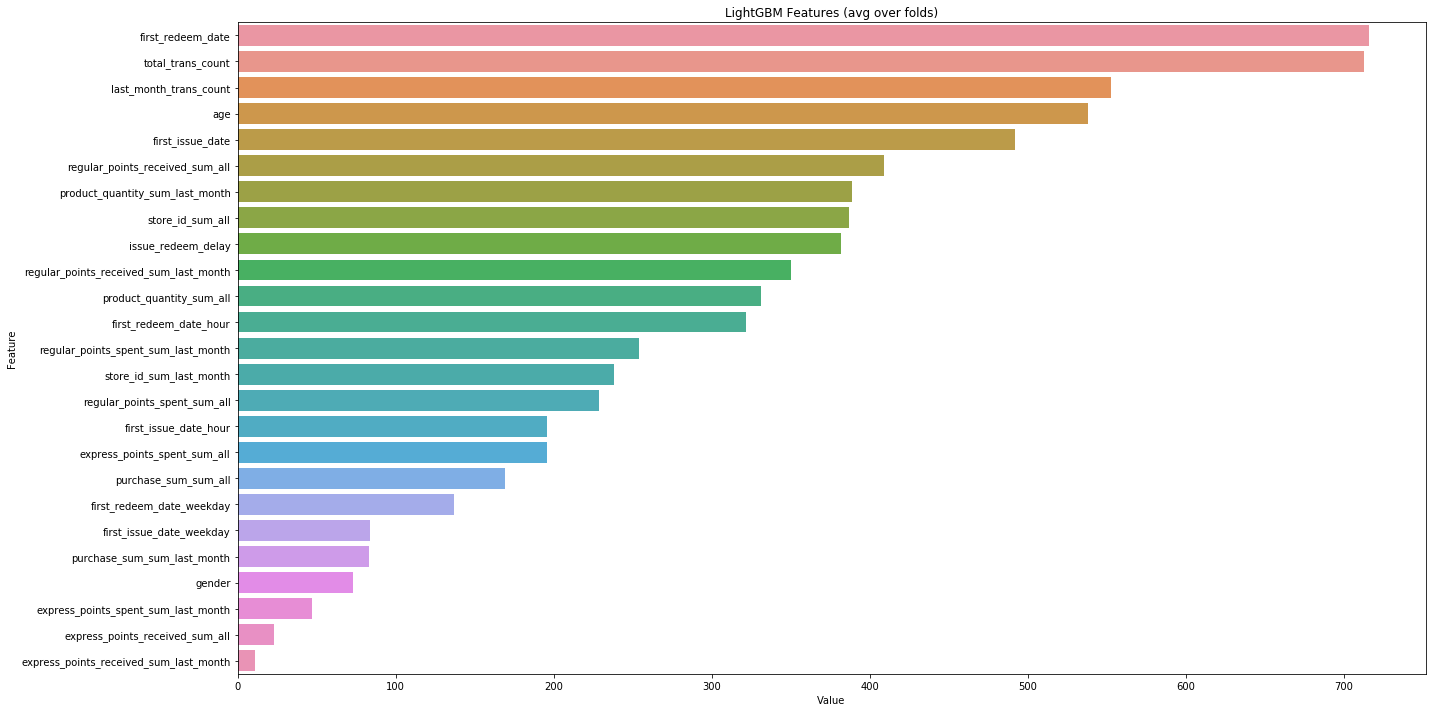

In [39]:
feature_imp = pd.DataFrame(sorted(zip(treatment_model.feature_importances_,treatment_x.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [43]:
df_test['target'] = 1
merged_test = pd.concat([df_test,clients,features],axis = 1,sort = True)
merged_test = merged_test[~merged_test['target'].isnull()].copy()

In [45]:
merged_test['first_issue_date_weekday'] = merged_test['first_issue_date'].dt.weekday
merged_test['first_redeem_date_weekday'] = merged_test['first_redeem_date'].dt.weekday
merged_test['first_issue_date_hour'] = merged_test['first_issue_date'].dt.hour
merged_test['first_redeem_date_hour'] = merged_test['first_redeem_date'].dt.hour
merged_test['first_issue_date'] = merged_test['first_issue_date'].astype(int)/10**9
merged_test['first_redeem_date'] = merged_test['first_redeem_date'].astype(int)/10**9
merged_test['diff'] = merged_test['first_redeem_date']-merged_test['first_issue_date']
merged_test['gender'] = list(ord(v[0]) for v in merged_test['gender'].values)

In [46]:
test_x = merged_test.drop('target',axis = 1)

In [47]:
preds_pos = treatment_model.predict_proba(test_x)[:,1]
preds_neg = control_model.predict_proba(test_x)[:,1]

In [48]:
df_submission = pd.DataFrame({'client_id':test_x.index.values,'uplift': preds_pos-preds_neg})
df_submission.to_csv('../submit/submission_lgbm.csv',index = False)

In [68]:
def uplift_fit_predict(model, X_train, treatment_train, target_train, X_test):
    """
    Реализация простого способа построения uplift-модели.
    
    Обучаем два бинарных классификатора, которые оценивают вероятность target для клиента:
    1. с которым была произведена коммуникация (treatment=1)
    2. с которым не было коммуникации (treatment=0)
    
    В качестве оценки uplift для нового клиента берется разница оценок вероятностей:
    Predicted Uplift = P(target|treatment=1) - P(target|treatment=0)
    """
    X_treatment, y_treatment = X_train[treatment_train == 1, :], target_train[treatment_train == 1]
    X_control, y_control = X_train[treatment_train == 0, :], target_train[treatment_train == 0]
    model_treatment = clone(model).fit(X_treatment, y_treatment)
    model_control = clone(model).fit(X_control, y_control)
    predict_treatment = model_treatment.predict_proba(X_test)[:, 1]
    predict_control = model_control.predict_proba(X_test)[:, 1]
    predict_uplift = predict_treatment - predict_control
    return predict_uplift


def uplift_score(prediction, treatment, target, rate=0.3):
    """
    Подсчет Uplift Score
    """
    order = np.argsort(-prediction)
    treatment_n = int((treatment == 1).sum() * rate)
    treatment_p = target[order][treatment[order] == 1][:treatment_n].mean()
    control_n = int((treatment == 0).sum() * rate)
    control_p = target[order][treatment[order] == 0][:control_n].mean()
    score = treatment_p - control_p
    return score

In [71]:
indices_train = df_train.index
indices_test = df_test.index
indices_learn, indices_valid = train_test_split(df_train.index, test_size=0.3, random_state=2029)

In [85]:
valid_uplift = uplift_fit_predict(
    model=LogisticRegression(),
    X_train=df_features.loc[indices_learn, :].fillna(0).values,
    treatment_train=df_train.loc[indices_learn, 'treatment_flg'].values,
    target_train=df_train.loc[indices_learn, 'target'].values,
    X_test=df_features.loc[indices_valid, :].fillna(0).values,
)
valid_score = uplift_score(
    valid_uplift,
    treatment=df_train.loc[indices_valid, 'treatment_flg'].values,
    target=df_train.loc[indices_valid, 'target'].values,
)
print('Validation score:', valid_score)

Validation score: 0.022711101346462592


In [86]:
# Подготовка предсказаний для тестовых клиентов

test_uplift = uplift_fit_predict(
    model=LogisticRegression(),
    X_train=df_features.loc[indices_train, :].fillna(0).values,
    treatment_train=df_train.loc[indices_train, 'treatment_flg'].values,
    target_train=df_train.loc[indices_train, 'target'].values,
    X_test=df_features.loc[indices_test, :].fillna(0).values,
)

df_submission = pd.DataFrame({'uplift': test_uplift}, index=df_test.index)
df_submission.to_csv('submission.csv')

# Ideads for features

<ul>
    <li>Mean features from purchases for client</li>
    <li>Std from mean </li>
    <li>Z-scores</li>
    <li>Divergense from median</li>
    <li>Min</li>
    <li>Max</li>
    <li>Total sum</li>
    <li>daytime for purchase</li>
    <li>most common category</li>
    <li>Buy alchocol</li>
    <li>most common level_i</li>
    <li>cluster for client</li>
</ul>